# Analysing Data from a CTD (Conductivity, Temperature, Depth) Sensor

This notebook provides a streamlined workflow for analysing data collected from a CTD (Conductivity, Temperature, Depth) sensor, a fundamental tool in oceanographic research used to profile water column properties. This CTD data can reveal insights into various physical and chemical characteristics of the ocean, including temperature, salinity, and density variations with depth. In this notebook, we will:

1. **Load Data**: Begin by loading the CTD data processed in Ruskin
2. **Data Processing and Despiking**: Clean and process the data, including a despiking step to remove noise and outliers, which improves data reliability.
3. **Data Visualisation**: Create plots to visualise key CTD parameters (such as temperature, salinity, and depth) and observe patterns across the depth profile.
4. **Correlation Analysis**: Investigate correlations within the dataset to explore relationships between different measured variables, such as temperature and salinity, and their potential impact on water density.

By the end of this notebook, you will have a clear and comprehensive analysis of the CTD data, providing insights into the vertical structure of the water column and the relationships among key oceanographic variables. This approach is ideal for initial CTD data exploration in marine science applications.


## Introduction to CTD Data for Coral Reef Monitoring

A CTD (Conductivity, Temperature, Depth) instrument is widely used in marine monitoring to measure essential physical and chemical properties of seawater. In coral reef environments, it provides insights into water conditions that are critical for reef health. The data collected includes:

- **Conductivity (mS/cm)**: Indicates salinity, or how salty the water is.
- **Temperature (°C)**: Measures water temperature, which can influence coral health and ecosystem dynamics.
- **Chlorophyll-a (µg/l)**: Reflects phytoplankton levels, which can indicate nutrient availability.
- **Temperature1 (°C)**: Duplicate sensor for temperature, useful for verification.
- **Dissolved Oxygen Concentration (µmol/L)**: Shows oxygen availability, essential for marine life.
- **PAR (µMol/m²/s)**: Photosynthetically Active Radiation, or light available for photosynthesis, which corals rely on.
- **pH (pH_units)**: Monitors acidity, as changes in pH can affect coral growth.

In this notebook, you'll analyze CTD data focusing on the above variables. Note that the `sea_pressure`, `depth`, and `velocity` fields were not recorded in this dataset.


Import the Necessary Packages

In [27]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#import pyrsktools

from scipy.signal import medfilt

# Step 1: Load the Data



Data from a CSV file named "sample_CTD_data.csv" is being read into a pandas DataFrame, and custom column names are being specified for the DataFrame. The desired column names have been defined in the "colnames" list. 

The CSV file is being read with specific parameters, including character encoding, and the first 11 rows, often containing header. 

Any rows containing missing values are being removed to clean the data, ensuring that only complete rows are retained. 

The "timestamp" column is being converted to datetime object.

In [28]:
excel_path = "data/2024_05_18.xlsx"

# Open the workbook (doesn't load all sheets yet)
xf = pd.ExcelFile(excel_path)

# Print tab (sheet) names
print("Sheets:", xf.sheet_names)


Sheets: ['Metadata', 'Events', 'Errors', 'Data']


C:\Users\lachl\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [29]:

# load a sheet by name
df = pd.read_excel(xf, sheet_name=xf.sheet_names[3], header = 1)

df.head()

,Time,Conductivity,Temperature,Chlorophyll a,Temperature.1,Dissolved O2 concentration,PAR,pH,Salinity,Speed of sound,Specific conductivity,Dissolved O2 saturation,Density anomaly
0,2024-04-09 13:30:00,-0.002517,30.258827,8.282186,28.75120,150.735336,538.774006,2.818467,0.014120,1509.755150,-2.287113,64.184480,NaN
1,2024-04-09 14:00:00,55.182160,26.909719,-0.006977,27.05860,216.398701,759.886722,8.727001,35.076480,1538.968972,53233.854659,105.775927,NaN
2,2024-04-09 14:30:00,55.157142,26.970301,0.020975,27.11295,226.608872,772.510425,8.742936,35.012827,1539.039248,53150.375471,110.838481,NaN
3,2024-04-09 15:00:00,55.213683,26.997427,0.030338,27.17390,233.802681,617.675680,8.759155,35.032778,1539.122145,53178.304419,114.421473,NaN
4,2024-04-09 15:30:00,55.265955,27.050299,0.061302,27.24545,238.540203,501.184821,8.775132,35.030242,1539.239552,53176.915507,116.840796,NaN


## Basic Data Visualization


Each subplot displays a distinct data channel from the CTD 

You can change the the aesthetics of the plot, including line width, tick label size, and y-axis labels for each subplot.

The x-axis label "Date" is being applied to all subplots, and the x-axis limits are being set to cover the entire time range of the data. 

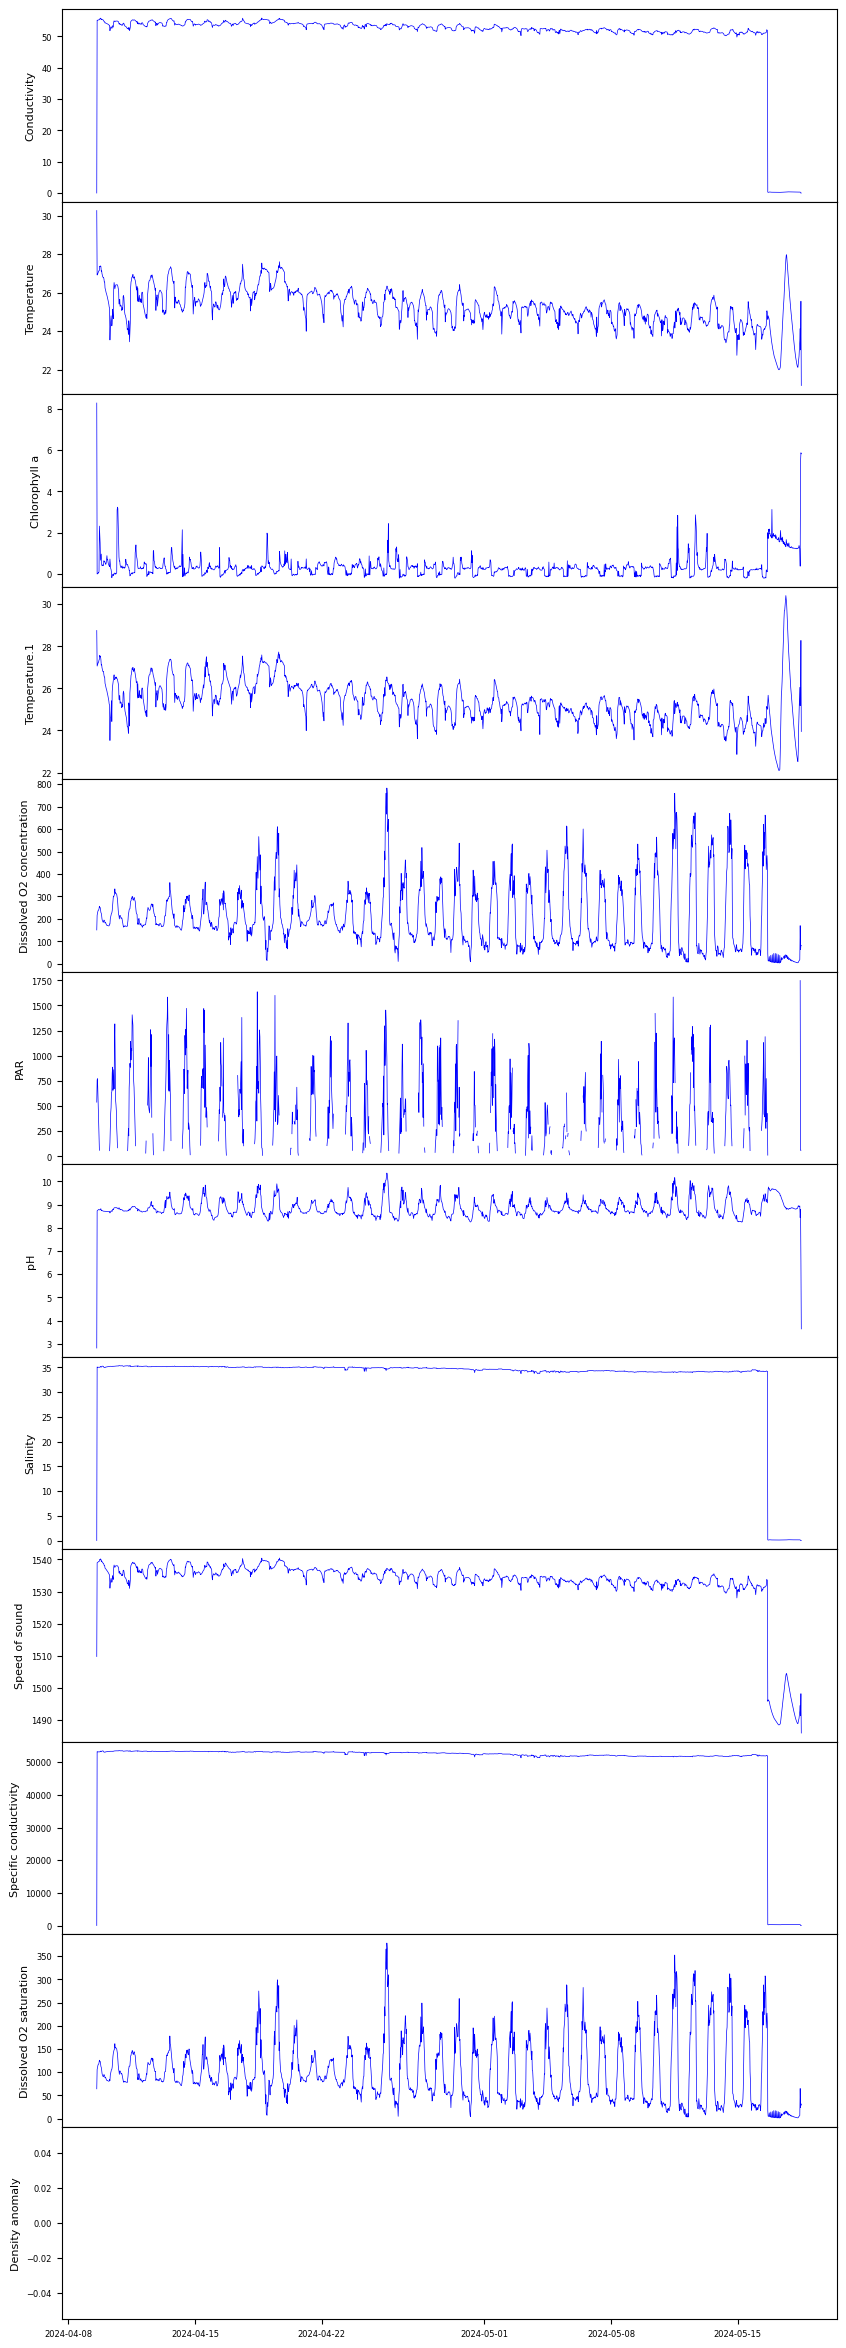

In [30]:
cols = df.columns

num_cols = len(cols)-1

fig, axs = plt.subplots(figsize=(10,30), nrows=num_cols, sharex=True, gridspec_kw={'hspace': 0})

for i in range(0,num_cols):
    col_name = i+1
    axs[i].plot(df.Time, df[[cols[col_name]]], lw=0.5, c='blue')
    axs[i].tick_params(axis='both', which='major', labelsize=6)
    axs[i].set_ylabel(df[[cols[col_name]]].columns[0], fontsize=8)

# Step 2: **Data Processing and Despiking**

First, check the data:

In [31]:
df

,Time,Conductivity,Temperature,Chlorophyll a,Temperature.1,Dissolved O2 concentration,PAR,pH,Salinity,Speed of sound,Specific conductivity,Dissolved O2 saturation,Density anomaly
0,2024-04-09 13:30:00,-0.002517,30.258827,8.282186,28.75120,150.735336,538.774006,2.818467,0.014120,1509.755150,-2.287113,64.184480,NaN
1,2024-04-09 14:00:00,55.182160,26.909719,-0.006977,27.05860,216.398701,759.886722,8.727001,35.076480,1538.968972,53233.854659,105.775927,NaN
2,2024-04-09 14:30:00,55.157142,26.970301,0.020975,27.11295,226.608872,772.510425,8.742936,35.012827,1539.039248,53150.375471,110.838481,NaN
3,2024-04-09 15:00:00,55.213683,26.997427,0.030338,27.17390,233.802681,617.675680,8.759155,35.032778,1539.122145,53178.304419,114.421473,NaN
4,2024-04-09 15:30:00,55.265955,27.050299,0.061302,27.24545,238.540203,501.184821,8.775132,35.030242,1539.239552,53176.915507,116.840796,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1866,2024-05-18 10:30:00,0.303080,23.503459,1.225332,26.04710,18.349779,NaN,8.939767,0.150625,1492.789341,311.963540,6.923955,NaN
1867,2024-05-18 11:00:00,0.296347,24.132949,0.374800,25.17880,170.039585,1747.563954,8.433059,0.145477,1494.522943,301.303378,64.922795,NaN
1868,2024-05-18 11:30:00,0.023097,23.026932,5.446592,25.50445,63.900392,60.293562,8.787923,0.018709,1491.301181,23.998630,23.876836,NaN
1869,2024-05-18 12:00:00,-0.001195,25.552563,5.870677,28.27965,81.883771,60.886562,6.546542,0.012508,1498.184283,-1.182159,32.072358,NaN


In [32]:
# Drop the column named 'Density Anomaly'
df = df.drop(columns=['Density anomaly'], errors='ignore')


# And the dataset runs too long! There is useless data at the end:
start = pd.to_datetime('2024-04-09 14:00:00')
end = pd.to_datetime('2024-05-15 14:00:00') # Instrument was removed from the water

print(f'Start Time: {start}. End Time: {end}. Duration of Analysis {end-start}')


df = df[(df['Time']>=start)&(df['Time']<=end)].reset_index(drop=True)


Start Time: 2024-04-09 14:00:00. End Time: 2024-05-15 14:00:00. Duration of Analysis 36 days 00:00:00


### and visualise the data again:

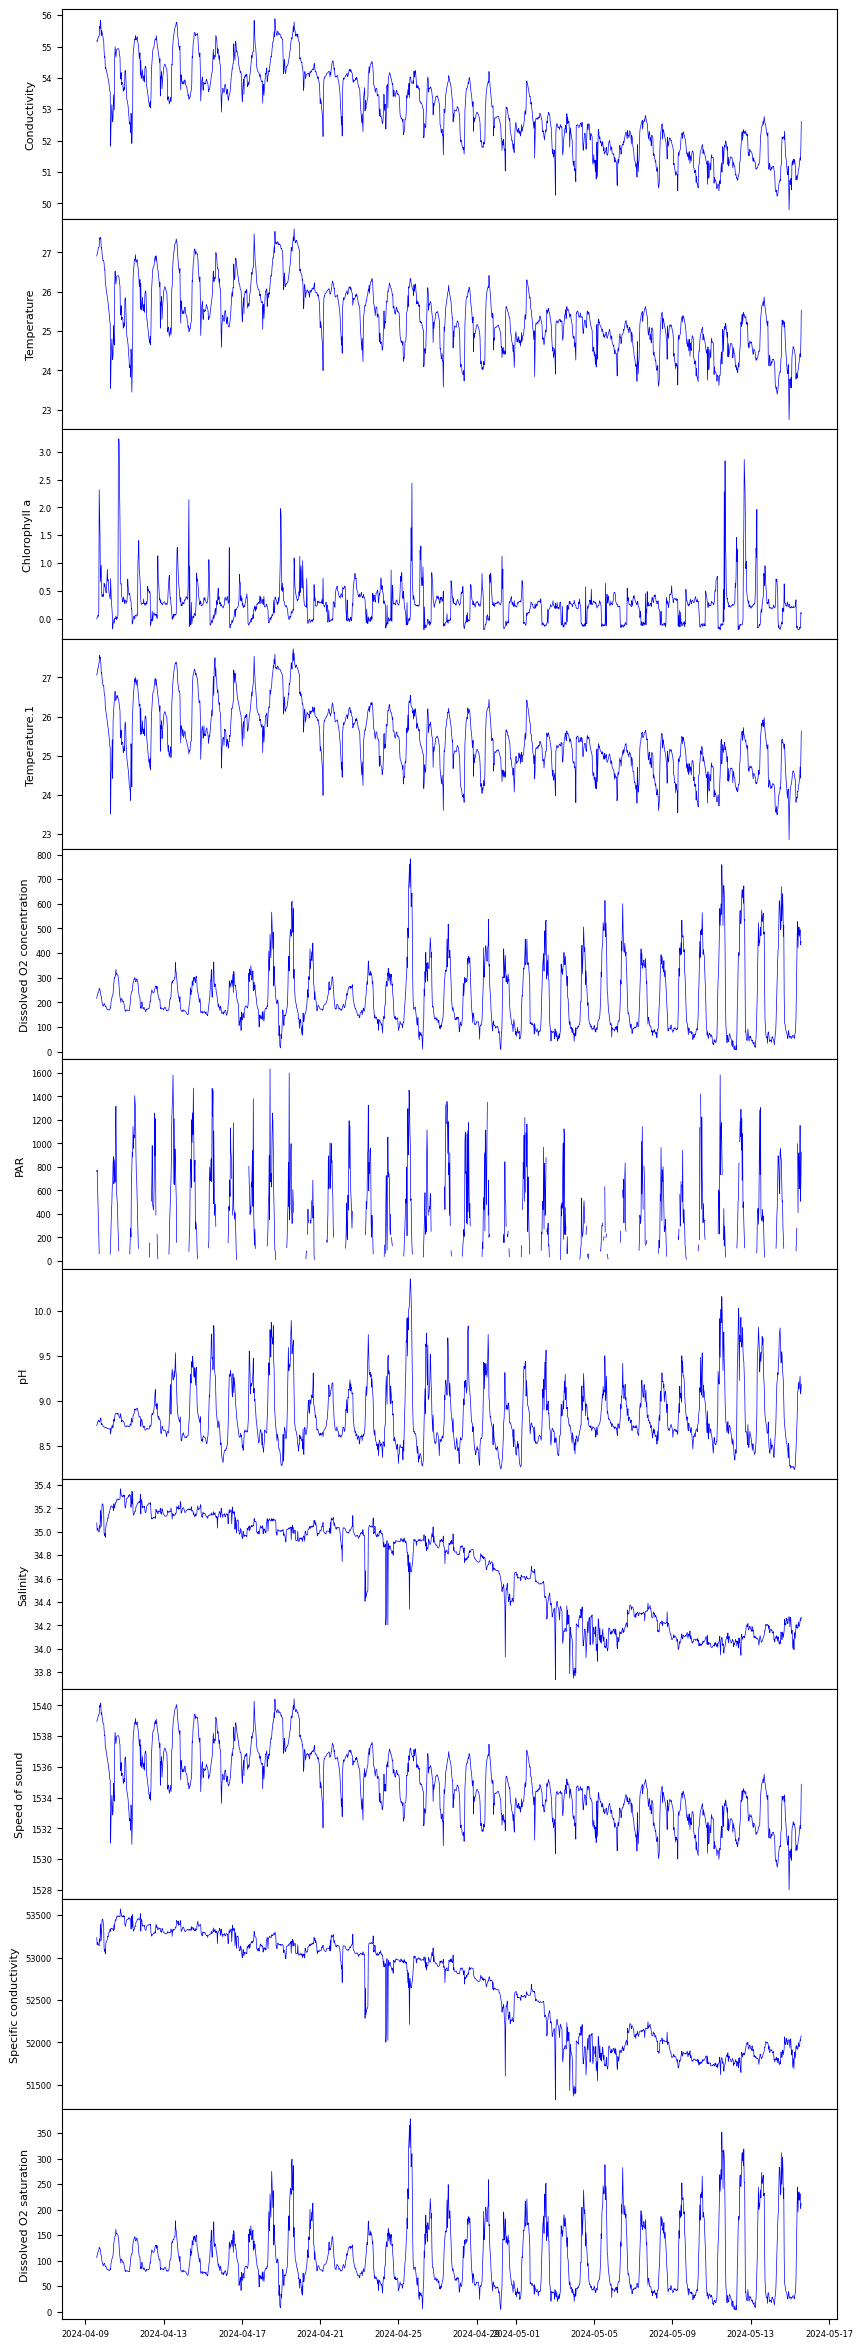

In [33]:
cols = df.columns
num_cols = len(cols)-1

fig, axs = plt.subplots(figsize=(10,30), nrows=num_cols, sharex=True, gridspec_kw={'hspace': 0})

for i in range(0,num_cols):
    col_name = i+1
    axs[i].plot(df.Time, df[[cols[col_name]]], lw=0.5, c='blue')
    axs[i].tick_params(axis='both', which='major', labelsize=6)
    axs[i].set_ylabel(df[[cols[col_name]]].columns[0], fontsize=8)

## Despiking data

Here we apply a filter to remove spikes from the data. Make sure you choose an appropriate window size for your analysis.<br/>
A larger window removes more noise but risks over-smoothing. For spike removal, a small to moderate size (e.g., 3-5) often works well. <br/>


In [34]:
df.columns

Index(['Time', 'Conductivity', 'Temperature', 'Chlorophyll a', 'Temperature.1',
       'Dissolved O2 concentration', 'PAR', 'pH', 'Salinity', 'Speed of sound',
       'Specific conductivity', 'Dissolved O2 saturation'],
      dtype='object')

In [35]:
# Apply a median filter to smooth out spikes
window_size = 5  # Choose an odd number for the window size (e.g., 3, 5, 7)
df['chlorophyll_despiked'] = medfilt(df['Chlorophyll a'], kernel_size=window_size)
#df = df.drop(columns=['Chlorophyll a'])

Text(0, 0.5, 'Chlorophyl a (µg/L)')

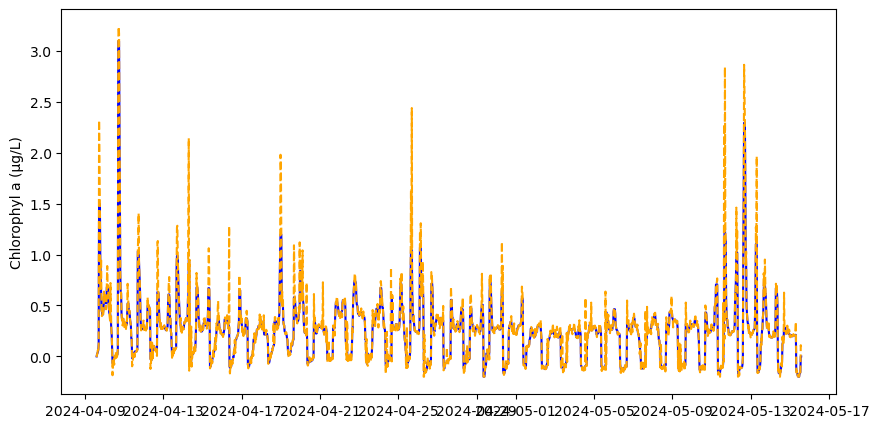

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df.Time, df['chlorophyll_despiked'], c='blue', label = 'Medfilt')
ax.plot(df.Time, df['Chlorophyll a'], c='orange', label = 'Raw data', ls = '--')
ax.set_ylabel('Chlorophyl a (µg/L)')

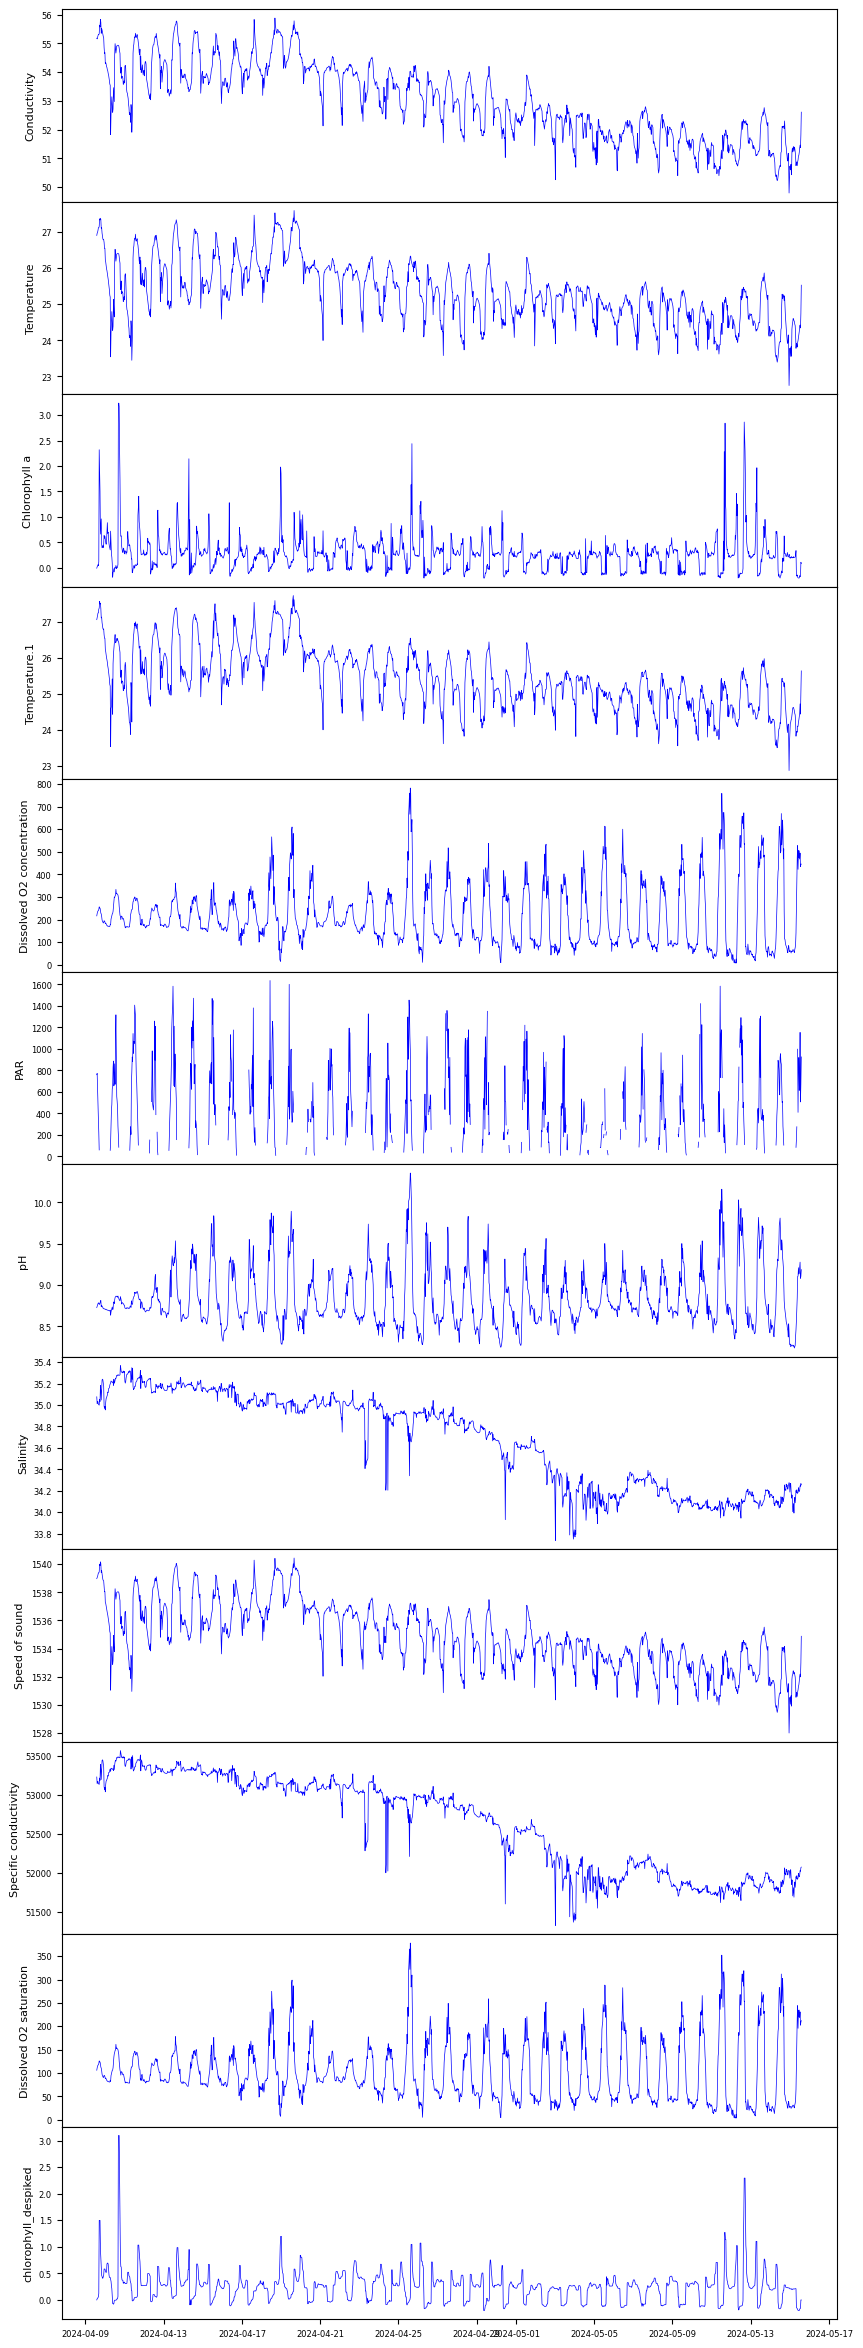

In [40]:
cols = df.columns
num_cols = len(cols)-1

fig, axs = plt.subplots(figsize=(10,30), nrows=num_cols, sharex=True, gridspec_kw={'hspace': 0})

for i in range(0,num_cols):
    col_name = i+1
    axs[i].plot(df.Time, df[[cols[col_name]]], lw=0.5, c='blue')
    axs[i].tick_params(axis='both', which='major', labelsize=6)
    axs[i].set_ylabel(df[[cols[col_name]]].columns[0], fontsize=8)

# Step 4: **Analyse cross-variable relationships**

This code identifies cross-variable relationships in CTD data, focusing on key environmental parameters like temperature, chlorophyll-a, dissolved oxygen saturation, and pH. It generates a correlation matrix to quantify relationships and scatter plots to visualize specific interactions. Analyzing these relationships is crucial for understanding the physical and chemical dynamics affecting coral reef health and detecting stress factors in the marine environment.


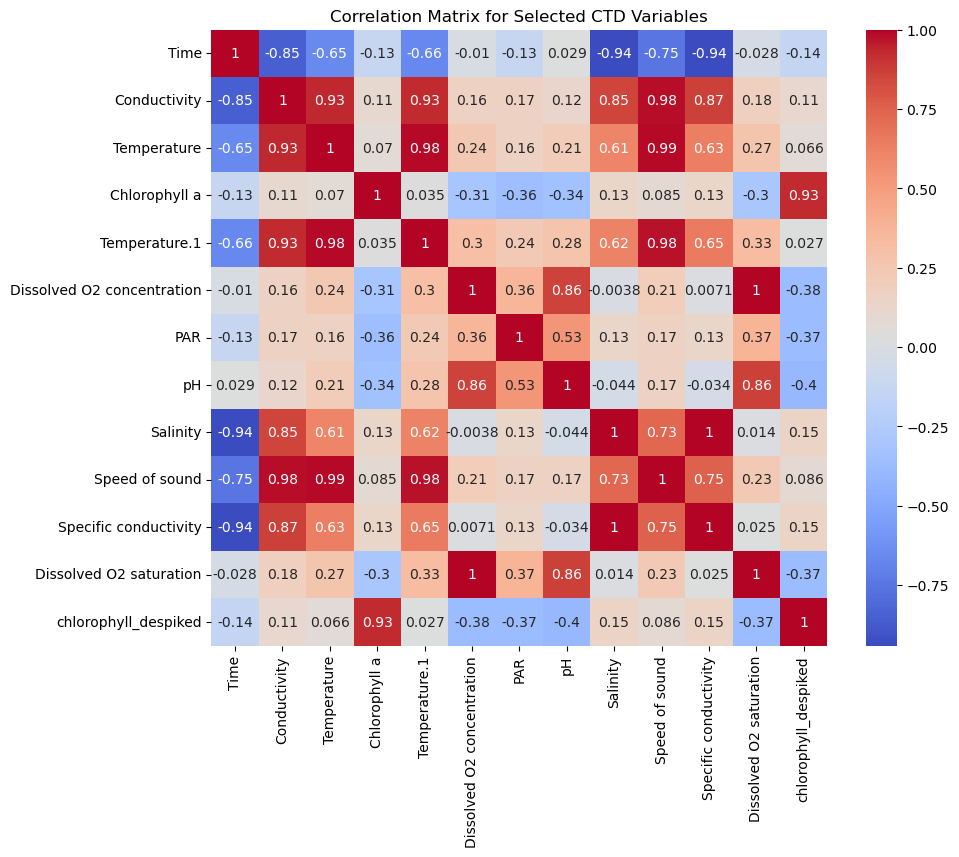

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate the correlation matrix for the selected variables
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)
plt.title('Correlation Matrix for Selected CTD Variables')
plt.show()
